In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import ast

 First we load all the dataset that we will be using

In [2]:
# Constants
characters_metadata_path = './data/MovieSummaries/character.metadata.tsv'
movies_metadata_path = './data/MovieSummaries/movie.metadata.tsv'
movie_summaries_path = './data/MovieSummaries/plot_summaries.txt'
imdb_ratings_path = './data/imdb/imdb_ratings.tsv'
imdb_titles_path = './data/imdb/imdb_titles.tsv'

colnames_charac=['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie=['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot=['Wikipedia movie ID', 'Plot'] 

In [3]:
# Load datasets 
meta_charac_raw = pd.read_csv(characters_metadata_path, names=colnames_charac, sep='\t')
meta_movie_raw = pd.read_csv(movies_metadata_path, names=colnames_movie, sep='\t')
plot = pd.read_csv(movie_summaries_path, names=colnames_plot, sep="\t")

imdb_raitings = pd.read_csv(imdb_ratings_path, header=0 , sep='\t')
imdb_title = pd.read_csv(imdb_titles_path, header=0, sep='\t', dtype= "string")

## Initial data analysis
First we will drop le columns that we will not be using as to not clutter our analysis


In [4]:
movie_columns_used = ['Wikipedia movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie genres'] 
charac_columns_used = ['Wikipedia movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
meta_movie = meta_movie_raw[movie_columns_used].copy()
meta_charac = meta_charac_raw[charac_columns_used].copy()

In [5]:
print("--- Meta Movie ---")
print(meta_movie.dtypes.to_string())
print("--- Meta Character ---")
print(meta_charac.dtypes.to_string())
print("--- Plot ---")
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date           object
Movie box office revenue    float64
Movie genres                 object
--- Meta Character ---
Wikipedia movie ID                   int64
Movie release date                  object
Character name                      object
Actor date of birth                 object
Actor gender                        object
Actor ethnicity                     object
Actor name                          object
Actor age                          float64
Freebase character/actor map ID     object
Freebase character ID               object
Freebase actor ID                   object
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


In [6]:
#TODO Check if we need ot do this ... -> objects are with NaNs I guess...
# meta_movie['Movie name'] = meta_movie['Movie name'].astype(str)

# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)
# meta_charac[['Character name', 'Actor gender','Actor ethnicity','Actor name']] = meta_charac[['Character name', 'Actor gender','Actor ethnicity','Actor name']].astype(str)
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())


TODO : Mieux expliquer

We will start by filtering the data by adding the IMDb scores. To do this we will need to have a look at the IMDb dataset.  Once the filtering id finished, we will then analyse what we have left.

In [7]:
imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() #keep only movies
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() #remove nan years
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) # turn year to int

movies = meta_movie\
            .merge(imdb_movieTitle[['primaryTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['primaryTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')

print("--- Movie dataset size ---")
print(movies.shape)

--- Movie dataset size ---
(39958, 10)


We will now have a look at the resulting datasets

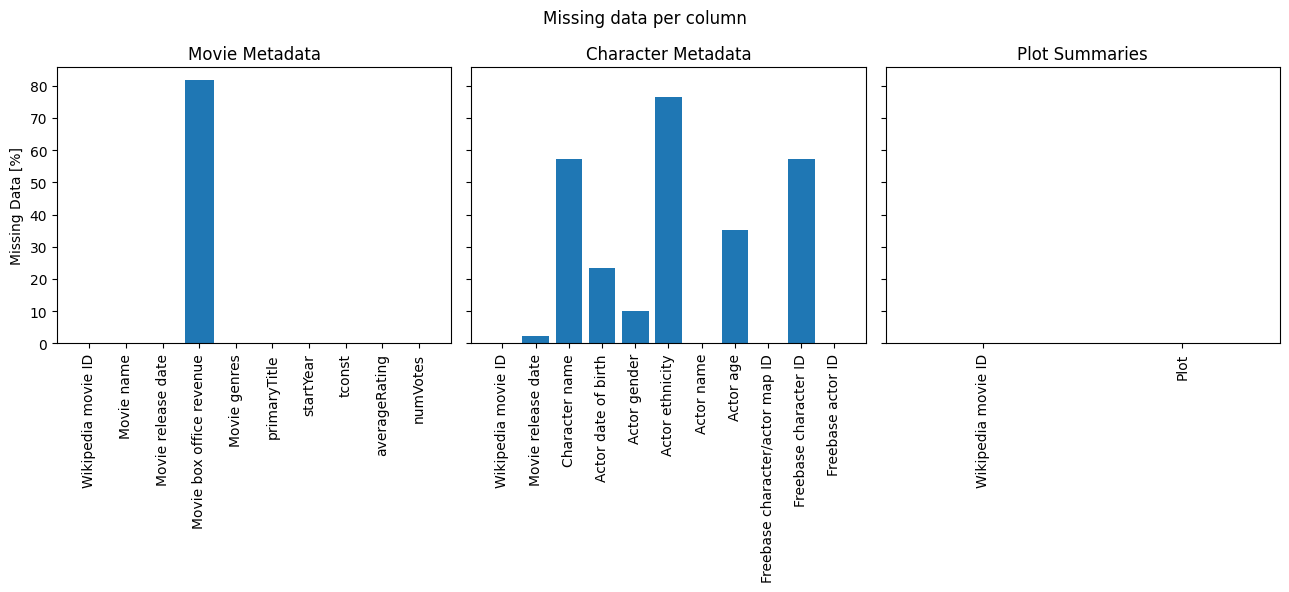

--- Dataset shapes ---
Movies metadata: (39958, 10)
Character metadata: (39958, 10)
Plot summaries: (42303, 2)


In [8]:
# Calculating missing data
missing_movie = movies.isnull().sum() * 100 / len(movies)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(movies.shape))
print("Character metadata: {}" .format(movies.shape))
print("Plot summaries: {}" .format(plot.shape))

From this initial analysis we can see that there is alot of missing data and that we should be carefull when selecting the actor features.


Now lets work on the movie genres, at the moment they are a long string: "{"/m/014dsx": "Travel", "/m/0219x_": "Indie", "/m/0jtdp": "Documentary"}". We can use the fact that they are a dictionary

In [9]:
# N.B Takes 20s to run
def count_genres(dictionary):
    return pd.Series(list(dictionary.values())).value_counts()

# Apply the custom function to the column
genre_counts = movies['Movie genres'].apply(count_genres).fillna(0).sum()


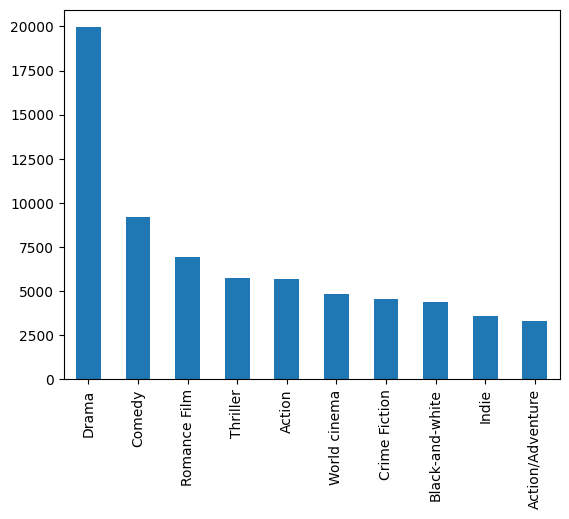

In [10]:
# Plot top 10 most represented genres
genre_counts = genre_counts.sort_values(ascending=False).head(10)
genre_counts.plot.bar()
drama_films = movies[movies['Movie genres'].apply(lambda x: 'Drama' in x.values())]
comedy_films = movies[movies['Movie genres'].apply(lambda x: 'Comedy' in x.values())]
romance_films = movies[movies['Movie genres'].apply(lambda x: 'Romance Film' in x.values())]

We will now look at the temporal distribution of films

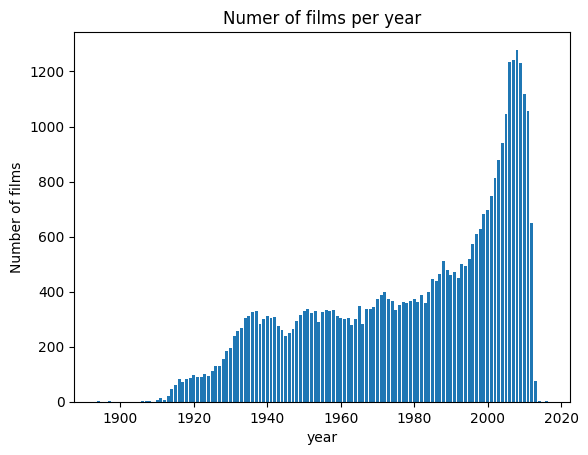

In [11]:

# Plot movies / year
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
plt.bar(movie_counts.index,movie_counts.values)
plt.title('Numer of films per year')
plt.xlabel('year')
plt.ylabel('Number of films')
plt.show()

TODO: Don't need any more
Since the first film is believed to have been recorded in 1888 [_Wikipedia_]. So there is a problem here: A typo in the data has put a film from 2010 as 1010

earliest film before typo correction: 1894
earliest film after typo correction: 1894


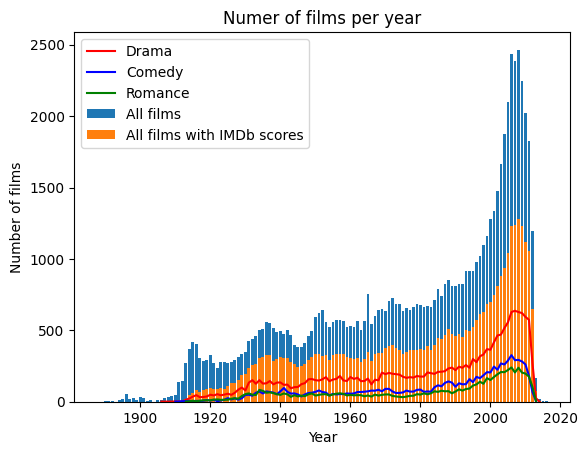

In [21]:
print("earliest film before typo correction: {}" .format(movies['Movie release date'].min()))

#correction TODO Don't need and change underneath
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

print("earliest film after typo correction: {}" .format(movies['Movie release date'].min()))

# Graph
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
drama_counts = drama_films['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
comedy_counts = comedy_films['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
romance_counts = romance_films['Wikipedia movie ID'].groupby(movies['Movie release date']).count()

plt.bar(all_movie_counts.index, all_movie_counts.values, label= 'All films')
plt.bar(movie_counts.index, movie_counts.values, label= 'All films with IMDb scores')
plt.plot(drama_counts.index, drama_counts.values, 'r-', label='Drama')
plt.plot(comedy_counts.index, comedy_counts.values, 'b-',label = 'Comedy')
plt.plot(romance_counts.index, romance_counts.values, 'g-', label = 'Romance')

plt.title('Numer of films per year')
plt.xlabel('Year')
plt.ylabel('Number of films')
plt.legend()
plt.show()

This is more what we where expecting, an exponential growth in films, exploding in the 1990s. Interestingly we can see that the data drops off after arounf 2010. We will have to be carefull when doing our temporal analyis since the data has such a negatice skew.